# *Machine Learning* em Reanimação Neonatal
Projeto 1 da Disciplina de Aprendizado de Máquina - PPgEEC/UFRN

## Etapa 5 - TEST

Neste notebook será realizada a etapa de teste do modelo utilizando os artefatos(*pipeline* e codificador) que foram construidos e armazenados no wandb.

## 1. Configuração do Ambiente

In [1]:
import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
!wandb login HASH --relogin

wandb: Appending key for api.wandb.ai to your netrc file: /Users/ericcalasans/.netrc


Será necessária a declaração das classes que foram construídas na etapa de treinamento para que o módulo **joblib** possa trabalhar efetivamente.

In [3]:
#from support import FeatureSelector, CategoricalTransformer, NumericalTransformer
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Construtor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Override de fit
    def fit(self, X, y=None):
        return self

    # Retorna as colunas passadas no construtor
    def transform(self, X, y=None):
        return X[self.feature_names]

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Construtor
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Override de fit
    def fit(self, X, y=None):
        return self

    # Override de get_feature_names_out
    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove eventuais espaços em branco dos valores - a princípio isso não existe na base de dados
        df = df.apply(lambda row: row.str.strip())

        # Opção de fazer preprocessamento se new_features for True(padrão da classe)
        if self.new_features:
            df['fumo'].fillna(2, inplace=True)
            df['alcool'].fillna(2, inplace=True)
            df['psicoativas'].fillna(2, inplace=True)
            df['tpp'].fillna(2, inplace=True)
            df['dheg'].fillna(2, inplace=True)
            df['dm'].fillna(2, inplace=True)
            df['sexo'].fillna(3, inplace=True)
            df['oligoamnio'].fillna(2, inplace=True)
            df['dpp'].fillna(2, inplace=True)
            df['sifilis'].fillna(2, inplace=True)
            df['hiv'].fillna(2, inplace=True)
            df['covid_mae'].fillna(2, inplace=True)

            # Elimina valores com sexo indefinido
            df.drop(df[df['sexo'] == 3].index, inplace=True)

            # Categoriza as features pois o artefato retorna sempre valores numéricos
            df['fumo'].replace([0, 1, 2, 3], ['n_fumo', 's_fumo', 'n_fumo', 'd_fumo'], inplace=True)
            df['alcool'].replace([0, 1, 2, 3], ['n_alcool', 's_alcool', 'n_alcool', 'd_alcool'], inplace=True)
            df['psicoativas'].replace([0, 1, 2, 3], ['n_psico', 's_psico', 'n_psico', 'd_psico'], inplace=True)
            df['tpp'].replace([0, 1, 2, 3], ['n_tpp', 's_tpp', 'n_tpp', 'd_tpp'], inplace=True)
            df['dheg'].replace([0, 1, 2, 3], ['n_dheg', 's_dheg', 'n_dheg', 'd_dheg'], inplace=True)

            # Melhor adequação da feature sexo
            df['sexo'].replace([1,2], ['Feminino', 'Masculino'], inplace=True)
            df['dpp'].replace([0, 1, 2, 3], ['n_dpp', 's_dpp', 'n_dpp', 'd_dpp'], inplace=True)
            df['oligoamnio'].replace([0, 1, 2, 3], ['n_oligo', 's_oligo', 'n_oligo', 'd_oligo'], inplace=True)
            df['sifilis'].replace([0, 1, 2, 3], ['n_sifilis', 's_sifilis', 'n_sifilis', 'd_sifilis'], inplace=True)
            df['hiv'].replace([0, 1, 2, 3], ['n_hiv', 's_hiv', 'n_hiv', 'd_hiv'], inplace=True)
            df['covid_mae'].replace([0, 1, 2, 3], ['n_covid', 's_covid', 'n_covid', 'd_covid'], inplace=True)

            # Consolidações
            df['dm'].replace([0,1,2,3,4,5,6], ['n_dm', 'n_dm','s_dm','s_dm', 's_dm','s_dm','d_dm'], inplace=True)

        self.colnames = df.columns

        return df


class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Tipos de scalers
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    def get_feature_names_out(self):
        return self.colnames

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

## 2.  Importação de Artefatos

Variáveis globais

In [4]:
# Artefato de teste
artifact_test_name = "mlreanimacao/test.csv:latest"

# Modelo
artifact_model_name = "mlreanimacao/model_export:latest"

# Codificador
artifact_encoder_name = "mlreanimacao/target_encoder:latest"

Configurações de logging

In [5]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

logger = logging.getLogger()

In [6]:
run = wandb.init(project='mlreanimacao', job_type='test')

wandb: Currently logged in as: ecalasans (use `wandb login --relogin` to force relogin)


In [7]:
logger.info("Lendo artefato...")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Excluindo target do dataframe...")
x_test = df_test.copy()
y_test = x_test.pop("reanimacao")

03-06-2022 11:32:08 Lendo artefato...
03-06-2022 11:32:10 Excluindo target do dataframe...


In [8]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idade_materna  151 non-null    float64
 1   fumo           151 non-null    object 
 2   alcool         151 non-null    object 
 3   psicoativas    151 non-null    object 
 4   tpp            151 non-null    object 
 5   dpp            151 non-null    object 
 6   oligoamnio     151 non-null    object 
 7   sifilis        151 non-null    object 
 8   hiv            151 non-null    object 
 9   covid_mae      151 non-null    object 
 10  dheg           151 non-null    object 
 11  dm             151 non-null    object 
 12  sexo           151 non-null    object 
dtypes: float64(1), object(12)
memory usage: 15.5+ KB


In [9]:
y_test.head()

0    sr
1    nr
2    nr
3    nr
4    nr
Name: reanimacao, dtype: object

Extração do codificador

In [10]:
logger.info("Extraindo codificador do artefato...")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

03-06-2022 11:32:31 Extraindo codificador do artefato...


Extração do *pipeline*

In [11]:
logger.info("Extraindo pipeline...")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

03-06-2022 11:32:38 Extraindo pipeline...


## 3.  Testagem

Codificação da *target*

In [12]:
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

03-06-2022 11:32:44 Classes [0, 1]: ['nr' 'sr']


Predição de valores

In [13]:
# predict
logger.info("Inferindo...")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Métricas de avaliação do teste")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Acurácia: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

03-06-2022 11:32:51 Inferindo...
03-06-2022 11:32:51 Métricas de avaliação do teste
03-06-2022 11:32:51 Acurácia: 0.4768211920529801
03-06-2022 11:32:51 Precision: 0.3333333333333333
03-06-2022 11:32:51 Recall: 0.25396825396825395
03-06-2022 11:32:51 Test F1: 0.28828828828828834


In [14]:
predict

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1])

Melhor formatação das métricas

In [15]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.54      0.64      0.59        88
           1       0.33      0.25      0.29        63

    accuracy                           0.48       151
   macro avg       0.44      0.45      0.44       151
weighted avg       0.46      0.48      0.46       151



Melhor formatação das métricas

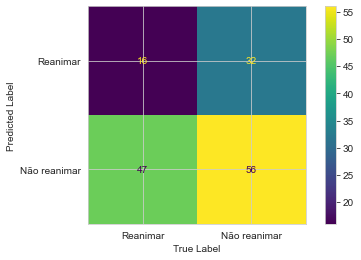

In [16]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=["Reanimar","Não reanimar"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

Observa-se uma redução da eficiência do modelo com dados desconhecidos, mesmo sendo otimizado.  Tal fato pode ser explicado pela baixa quantidade de dados para modelagem.  Uma possibilidade de correção ou melhoria seria ajustar a divisão do conjunto de treinamento/teste e retreinar o modelo.

*Upload* de figuras para o wandb e encerramento da execução.

In [21]:
logger.info("Salvando figuras...")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

03-06-2022 11:45:27 Salvando figuras...


Exception: The wandb backend process has shutdown

In [20]:
run.finish()

Acc,0.47682
F1,0.28829
Precision,0.33333
Recall,0.25397
